In [1]:
%load_ext autoreload
%autoreload 2

import torch
from math import pi
import matplotlib.pyplot as plt
import numpy as np
from torchkbnufft import KbNufft

In [2]:
nufft_forward = KbNufft(im_size=(128, 128, 128), grid_size=[2 * s for s in (128, 128, 128)])

In [3]:
# nufft_forward(image, torch.rand(3, 12) * 2 * pi - pi).shape

In [4]:
from neurorient.reconstruction.slicing import gen_nonuniform_normalized_positions, gen_model_slices

In [5]:
spi_data = torch.load('/pscratch/sd/z/zhantao/neurorient_repo/data/1bxr_train.pt')
print(spi_data['time_stamp'], spi_data.keys())

20230825-0248 dict_keys(['orientations', 'images', 'angles', 'points', 'pixel_position_reciprocal', 'volume', 'img_real_mesh', 'vol_real_mesh', 'time_stamp'])


In [6]:
from neurorient.reconstruction.slicing import get_rho_function

In [7]:
rho = torch.fft.fftshift(torch.fft.ifftn(torch.fft.ifftshift(spi_data['volume']))).real.clip(0)
rho_func = get_rho_function(spi_data['vol_real_mesh'], rho)
rho_img_coords = torch.from_numpy(rho_func(spi_data['img_real_mesh'].numpy()))

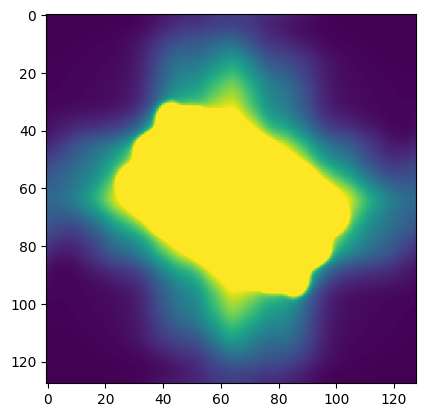

In [8]:
intensity = torch.fft.fftshift(torch.fft.fftn(rho_img_coords).abs().pow(2))
ac = torch.fft.ifftshift(torch.fft.ifftn(intensity).abs())
plt.imshow(ac[64].numpy(), vmax=ac.max().item() * 0.01)

In [124]:
slices = gen_model_slices(
    nufft_forward, 
    ac, spi_data['orientations'][:10], spi_data['pixel_position_reciprocal'],
)

In [125]:
slices_ = slices.reshape(10, 128, 128)

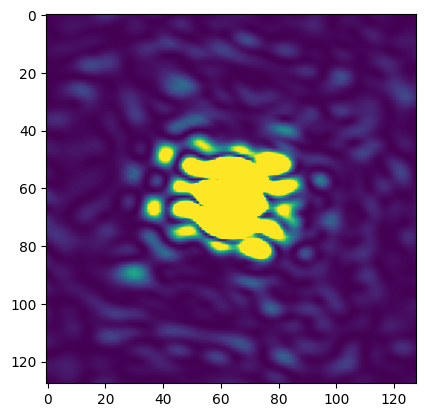

In [126]:
plt.imshow(spi_data['images'][8], vmax=spi_data['images'][8].max() * 1e-3)

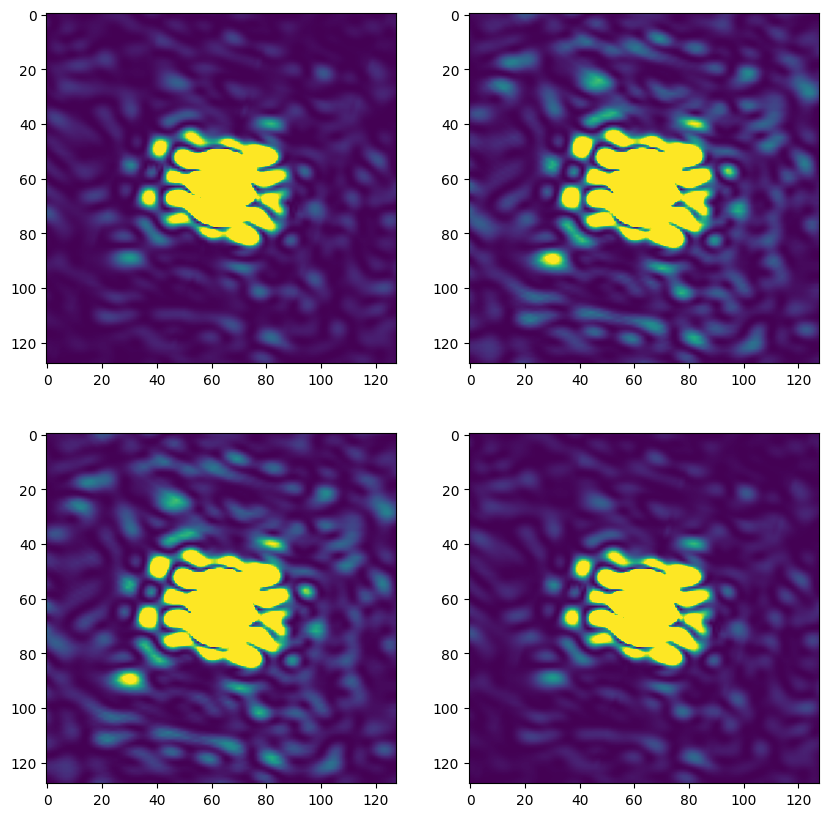

In [127]:
img_idx = 8

slice1_norm = slices_[img_idx].clip(0) / slices_[img_idx].clip(0).max()
slice2_norm = spi_data['images'][img_idx] / spi_data['images'][img_idx].max()

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0,0].imshow(slices_[img_idx].clip(0), vmax=slices_[img_idx].max() * 0.0005)
ax[0,1].imshow(spi_data['images'][img_idx], vmax=spi_data['images'][img_idx].max() * 0.0005)
ax[1,1].imshow(slice1_norm, vmax=0.0005)
ax[1,0].imshow(slice2_norm, vmax=0.0005)


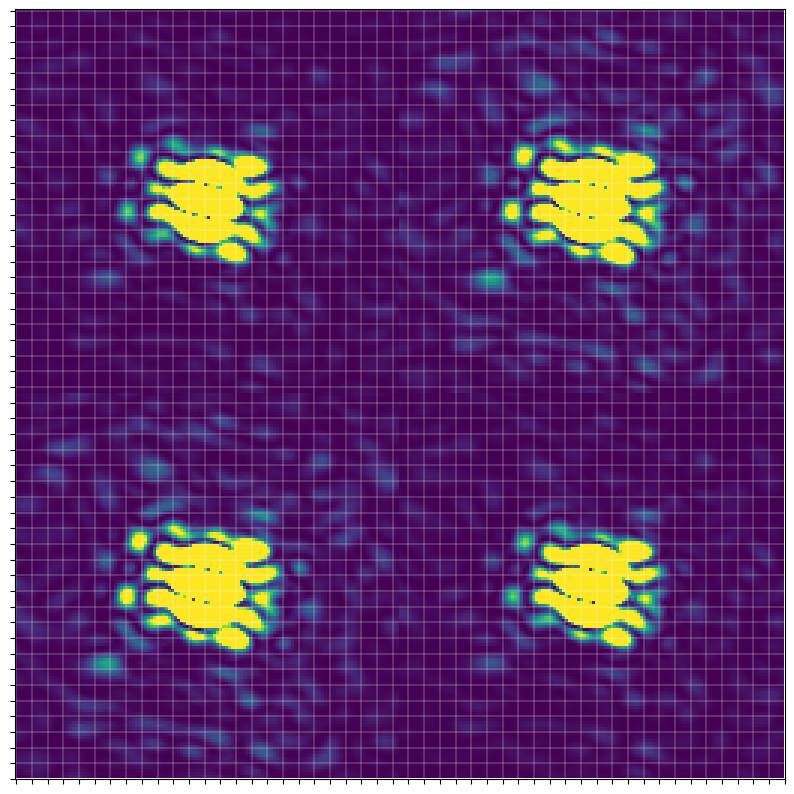

In [155]:
def concatenate_images(img1, img2, img3, img4):
    """Concatenate four images into a 2x2 grid."""
    top_row = np.hstack([img1, img2])
    bottom_row = np.hstack([img3, img4])
    return np.vstack([top_row, bottom_row])

img = concatenate_images(slice1_norm, slice2_norm, slice2_norm, slice1_norm)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(img, vmax = 1e-3)
ax.grid(which='both', color='white', linewidth=.25)
ax.set_xticks(np.linspace(0,img.shape[0], 50));
ax.set_yticks(np.linspace(0,img.shape[1], 50));
ax.set_xticklabels([]);
ax.set_yticklabels([]);
# plt.axis('off')

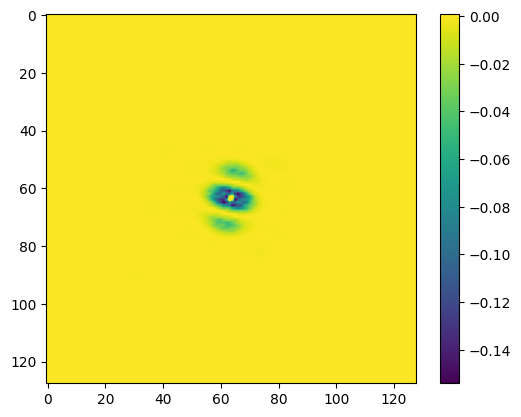

In [109]:
plt.imshow(slice1_norm-slice2_norm, vmax=0.001)
plt.colorbar()

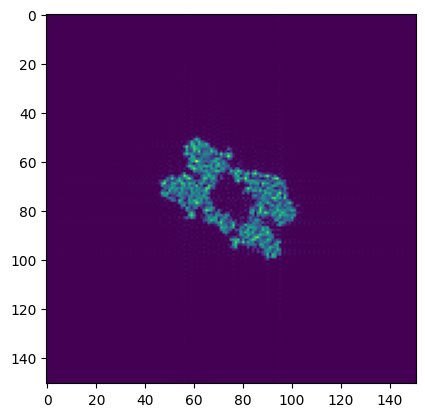

In [70]:
plt.imshow(rho[75])

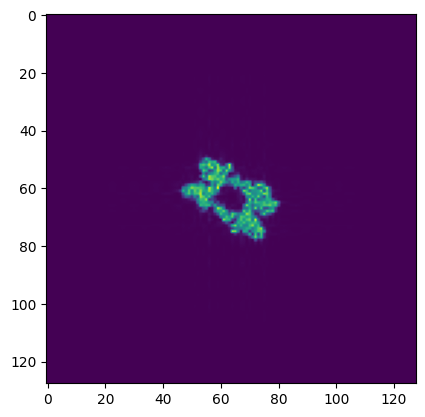

In [71]:
plt.imshow(rho_img_coords[64])